# Training of UNET

The aim of this notebook is to train two times the UNET model, once using the training data with simple data augmentations (rotation by multiples of 90 degrees, horizontal and vertical flips), and the second time with said data augmentation and distortions added to the training data (non-uniform illumination and gaussian noise).

### $\bullet$ Importing libraries and utilitary functions

In [1]:
# Import python libraries.
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
%load_ext autoreload
%autoreload 2
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import tensorflow
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Import utilitary functions and module defining the Unet model.
from utils import get_dataset_from_folders
from train_data_augmentation import make_train_generator
from unet import Unet
from plots import plot_history

In [2]:
# Set seeds of random number generators to guarantee reproducibility.
np.random.seed(1)
tensorflow.random.set_seed(2)

### $\bullet$ Setting size of the input image and different paths

In [3]:
# Shape of the inputs of the deep network.
images_shape = (256, 256, 1)

# Variables defining the path to the dataset.
train_input_path  = '../Dataset/train/input/'
train_output_path = '../Dataset/train/output/'
val_input_path    = '../Dataset/validation/input/'
val_output_path   = '../Dataset/validation/output/'
test_input_path   = '../Dataset/test/input/'
test_output_path  = '../Dataset/test/output/'

# Variable defining where models will be stored.
unet_original_save_path       = "../Models/Unet Original/"
unet_data_augmented_save_path = "../Models/Unet Data Augmented/"
unet_data_distorted_save_path = "../Models/Unet Data Distorted/"

### $\bullet$ Load images from the dataset

In [4]:
train_images, train_masks = get_dataset_from_folders(train_input_path, train_output_path, images_shape)
val_images, val_masks = get_dataset_from_folders(val_input_path, val_output_path, images_shape)
test_images, test_masks = get_dataset_from_folders(test_input_path, test_output_path, images_shape)

print(f'Training set contains {len(train_images)} images.')
print(f'Validation set contains {len(val_images)} images.')
print(f'Test set contains {len(test_images)} images.')

Training set contains 606 images.
Validation set contains 96 images.
Test set contains 510 images.


### $\bullet$ Training original model which used no data augmentations

In [5]:
# Setting up parameters used for training
number_epochs = 100
batch_size = 2
early_stopping = EarlyStopping(patience=50, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath=unet_original_save_path, save_weights_only=False, monitor='val_accuracy', mode='max', save_best_only=True)

# Building Unet model.
model = Unet(images_shape, show_summary=True)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 16) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [6]:
# Training
history = model.fit(train_images, train_masks, validation_data = (val_images, val_masks), batch_size = batch_size, epochs=number_epochs, callbacks=[early_stopping, model_checkpoint])

Train on 606 samples, validate on 96 samples
Epoch 1/100
604/606 [============================>.] - ETA: 0s - loss: 0.8820 - accuracy: 0.9413WARNING:tensorflow:From C:\Anaconda3\lib\site-packages\tensorflow_core\python\ops\resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ../Models/Unet Original/assets
606/606 [==============================] - 23s 39ms/sample - loss: 0.8793 - accuracy: 0.9414 - val_loss: 0.0658 - val_accuracy: 0.9740
Epoch 2/100
606/606 [==============================] - 19s 32ms/sample - loss: 0.0653 - accuracy: 0.9752 - val_loss: 0.0502 - val_accuracy: 0.9807
Epoch 3/100
606/606 [==============================] - 19s 32ms/sample - loss: 0.0563 - accuracy: 0.9783 - val_loss: 0.0464 - val_accuracy: 0.9821
Epoch 4/10

606/606 [==============================] - 16s 27ms/sample - loss: 0.0217 - accuracy: 0.9909 - val_loss: 0.0609 - val_accuracy: 0.9840
Epoch 43/100
606/606 [==============================] - 16s 27ms/sample - loss: 0.0209 - accuracy: 0.9912 - val_loss: 0.0619 - val_accuracy: 0.9836
Epoch 44/100
606/606 [==============================] - 16s 27ms/sample - loss: 0.0203 - accuracy: 0.9914 - val_loss: 0.0604 - val_accuracy: 0.9842
Epoch 45/100
606/606 [==============================] - 21s 34ms/sample - loss: 0.0205 - accuracy: 0.9913 - val_loss: 0.0634 - val_accuracy: 0.9849
Epoch 46/100
606/606 [==============================] - 16s 26ms/sample - loss: 0.0204 - accuracy: 0.9915 - val_loss: 0.0535 - val_accuracy: 0.9832
Epoch 47/100
606/606 [==============================] - 16s 27ms/sample - loss: 0.0200 - accuracy: 0.9916 - val_loss: 0.0610 - val_accuracy: 0.9843
Epoch 48/100
606/606 [==============================] - 16s 27ms/sample - loss: 0.0196 - accuracy: 0.9918 - val_loss: 0.0598 

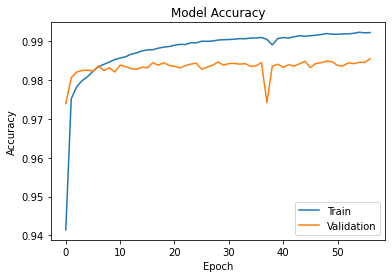

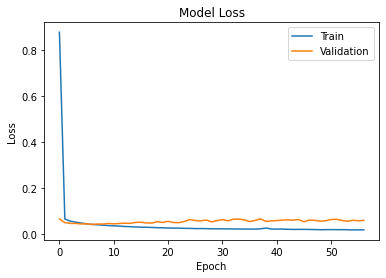

In [7]:
plot_history(history)

In [8]:
model.evaluate(test_images, test_masks);

510/510 [==============================] - 6s 12ms/sample - loss: 0.0277 - accuracy: 0.9892


### $\bullet$ Training model using images with simple data augmentations and no distortions

In [9]:
# Setting up parameters used for training
number_epochs = 200
batch_size = 2
steps_per_epoch = np.ceil(len(train_images)/batch_size).astype(np.uint)
early_stopping = EarlyStopping(patience=80, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath=unet_data_augmented_save_path, save_weights_only=False, monitor='val_accuracy', mode='max', save_best_only=True)

# Building Unet model.
model = Unet(images_shape, show_summary=False)

In [10]:
# Training
train_generator = make_train_generator(train_images, train_masks, batch_size=batch_size, custom_distortions=False)
history = model.fit(train_generator, validation_data=(val_images, val_masks), steps_per_epoch=steps_per_epoch, batch_size=batch_size, epochs=number_epochs, callbacks=[early_stopping, model_checkpoint])

  ...
    to  
  ['...']
Train for 303 steps, validate on 96 samples
Epoch 1/200
303/303 [==============================] - 22s 72ms/step - loss: 0.3757 - accuracy: 0.9504 - val_loss: 0.0562 - val_accuracy: 0.9795
Epoch 2/200
303/303 [==============================] - 20s 67ms/step - loss: 0.0592 - accuracy: 0.9772 - val_loss: 0.0473 - val_accuracy: 0.9827
Epoch 3/200
303/303 [==============================] - 20s 67ms/step - loss: 0.0526 - accuracy: 0.9798 - val_loss: 0.0448 - val_accuracy: 0.9830
Epoch 4/200
303/303 [==============================] - 20s 68ms/step - loss: 0.0498 - accuracy: 0.9807 - val_loss: 0.0444 - val_accuracy: 0.9836
Epoch 5/200
303/303 [==============================] - 20s 67ms/step - loss: 0.0476 - accuracy: 0.9814 - val_loss: 0.0421 - val_accuracy: 0.9841
Epoch 6/200
303/303 [==============================] - 16s 52ms/step - loss: 0.0458 - accuracy: 0.9819 - val_loss: 0.0417 - val_accuracy: 0.9840
Epoch 7/200
303/303 [==============================] - 20s 68

303/303 [==============================] - 16s 53ms/step - loss: 0.0311 - accuracy: 0.9871 - val_loss: 0.0390 - val_accuracy: 0.9860
Epoch 42/200
303/303 [==============================] - 16s 53ms/step - loss: 0.0307 - accuracy: 0.9872 - val_loss: 0.0365 - val_accuracy: 0.9859
Epoch 43/200
303/303 [==============================] - 16s 54ms/step - loss: 0.0308 - accuracy: 0.9871 - val_loss: 0.0378 - val_accuracy: 0.9848
Epoch 44/200
303/303 [==============================] - 16s 54ms/step - loss: 0.0304 - accuracy: 0.9873 - val_loss: 0.0405 - val_accuracy: 0.9832
Epoch 45/200
303/303 [==============================] - 16s 54ms/step - loss: 0.0302 - accuracy: 0.9874 - val_loss: 0.0391 - val_accuracy: 0.9843
Epoch 46/200
303/303 [==============================] - 17s 55ms/step - loss: 0.0299 - accuracy: 0.9875 - val_loss: 0.0374 - val_accuracy: 0.9857
Epoch 47/200
303/303 [==============================] - 2620s 9s/step - loss: 0.0303 - accuracy: 0.9875 - val_loss: 0.0414 - val_accuracy

303/303 [==============================] - 16s 54ms/step - loss: 0.0260 - accuracy: 0.9892 - val_loss: 0.0401 - val_accuracy: 0.9851
Epoch 97/200
303/303 [==============================] - 16s 54ms/step - loss: 0.0264 - accuracy: 0.9890 - val_loss: 0.0378 - val_accuracy: 0.9856
Epoch 98/200
303/303 [==============================] - 17s 55ms/step - loss: 0.0258 - accuracy: 0.9892 - val_loss: 0.0399 - val_accuracy: 0.9857
Epoch 99/200
303/303 [==============================] - 17s 55ms/step - loss: 0.0256 - accuracy: 0.9893 - val_loss: 0.0417 - val_accuracy: 0.9856
Epoch 100/200
303/303 [==============================] - 16s 54ms/step - loss: 0.0257 - accuracy: 0.9893 - val_loss: 0.0384 - val_accuracy: 0.9861
Epoch 101/200
303/303 [==============================] - 16s 53ms/step - loss: 0.0255 - accuracy: 0.9893 - val_loss: 0.0417 - val_accuracy: 0.9861
Epoch 102/200
303/303 [==============================] - 16s 54ms/step - loss: 0.0257 - accuracy: 0.9893 - val_loss: 0.0408 - val_accur

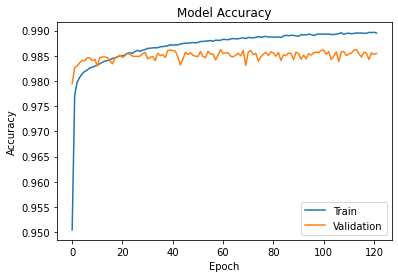

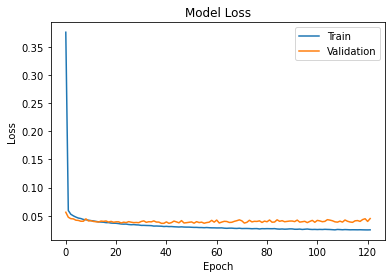

In [11]:
plot_history(history)

In [12]:
model.evaluate(test_images, test_masks);

510/510 [==============================] - 4s 7ms/sample - loss: 0.0226 - accuracy: 0.9908


### $\bullet$ Training model using images with simple data augmentations as well as distortions

In [13]:
# Setting up parameters used for training
number_epochs = 200
batch_size = 2
steps_per_epoch = np.ceil(len(train_images)/batch_size).astype(np.uint)
early_stopping = EarlyStopping(patience=80, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath=unet_data_distorted_save_path, save_weights_only=False, monitor='val_accuracy', mode='max', save_best_only=True)

# Building Unet model.
model = Unet(images_shape, show_summary=False)

In [14]:
# Training
train_generator = make_train_generator(train_images, train_masks, batch_size=batch_size, custom_distortions=True)
history = model.fit(train_generator, validation_data=(val_images, val_masks), steps_per_epoch=steps_per_epoch, batch_size=batch_size, epochs=number_epochs, callbacks=[early_stopping, model_checkpoint])

  ...
    to  
  ['...']
Train for 303 steps, validate on 96 samples
Epoch 1/200
303/303 [==============================] - 23s 75ms/step - loss: 0.5970 - accuracy: 0.8920 - val_loss: 0.1314 - val_accuracy: 0.9437
Epoch 2/200
303/303 [==============================] - 21s 68ms/step - loss: 0.2587 - accuracy: 0.9108 - val_loss: 0.1008 - val_accuracy: 0.9559
Epoch 3/200
303/303 [==============================] - 16s 53ms/step - loss: 0.2498 - accuracy: 0.9129 - val_loss: 0.1587 - val_accuracy: 0.9017
Epoch 4/200
303/303 [==============================] - 21s 70ms/step - loss: 0.2408 - accuracy: 0.9148 - val_loss: 0.0747 - val_accuracy: 0.9761
Epoch 5/200
303/303 [==============================] - 16s 53ms/step - loss: 0.2426 - accuracy: 0.9134 - val_loss: 0.1043 - val_accuracy: 0.9602
Epoch 6/200
303/303 [==============================] - 16s 54ms/step - loss: 0.2396 - accuracy: 0.9139 - val_loss: 0.1115 - val_accuracy: 0.9628
Epoch 7/200
303/303 [==============================] - 17s 55

Epoch 49/200
303/303 [==============================] - 17s 55ms/step - loss: 0.2249 - accuracy: 0.9177 - val_loss: 0.1279 - val_accuracy: 0.9537
Epoch 50/200
303/303 [==============================] - 17s 55ms/step - loss: 0.2292 - accuracy: 0.9157 - val_loss: 0.1145 - val_accuracy: 0.9691
Epoch 51/200
303/303 [==============================] - 17s 55ms/step - loss: 0.2288 - accuracy: 0.9161 - val_loss: 0.1214 - val_accuracy: 0.9665
Epoch 52/200
303/303 [==============================] - 17s 55ms/step - loss: 0.2226 - accuracy: 0.9188 - val_loss: 0.1045 - val_accuracy: 0.9774
Epoch 53/200
303/303 [==============================] - 17s 55ms/step - loss: 0.2288 - accuracy: 0.9164 - val_loss: 0.1329 - val_accuracy: 0.9474
Epoch 54/200
303/303 [==============================] - 17s 55ms/step - loss: 0.2265 - accuracy: 0.9170 - val_loss: 0.0988 - val_accuracy: 0.9734
Epoch 55/200
303/303 [==============================] - 17s 55ms/step - loss: 0.2228 - accuracy: 0.9191 - val_loss: 0.1090 -

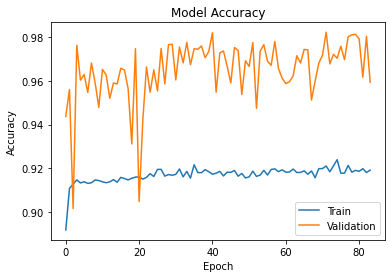

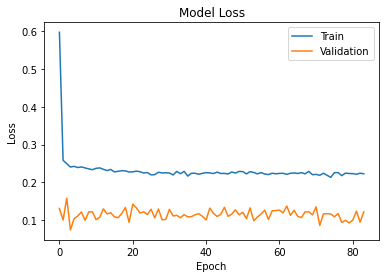

In [15]:
plot_history(history)

In [16]:
model.evaluate(test_images, test_masks);

510/510 [==============================] - 4s 7ms/sample - loss: 0.0554 - accuracy: 0.9832
